# 05.11 - k-Means Clustering

Here we will move on to another class of unsupervised machine learning models: **clustering algorithms**. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

### Introducing k-Means

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. The algorithm operates following two basic principles:

* The "cluster center" is the arithmetic mean of all the points belonging to the cluster
* Each point is closer to its own cluster center than to other cluster centers

Let's see an example:

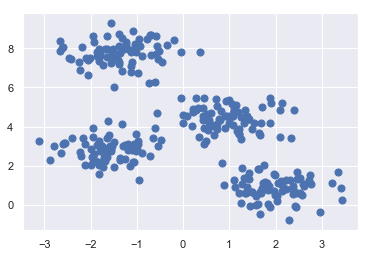

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

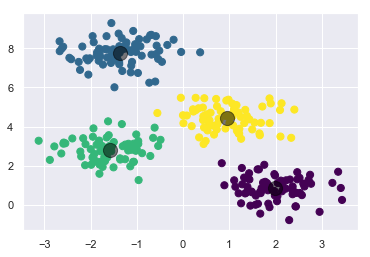

In [4]:
# plotting data colored by labels we found + cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

But how does k-Means find these groupings so quickly? Clearly, going through all possible combinations would take a lot. To understand this, we have to understand **expectation–maximization**.

### k-Means Algorithm: Expectation–Maximization

In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    * E-Step: assign points to the nearest cluster center
    * M-Step: set the cluster centers to the mean

The k-Means algorithm is simple enough that we can write it in a few lines of code:

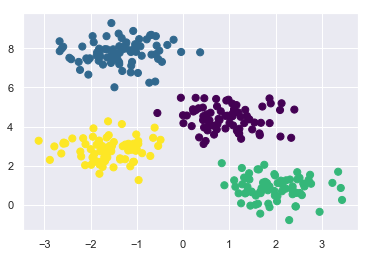

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Caveats of expectation–maximization

**1. The globally optimum result may not be achieved**

In this case, it would be useful to run the algorithm multiple times, as Scikit-learn already does by default. 

**2. The number of clusters must be selected beforehand**

k-means cannot learn the number of clusters from the data. 

**3. k-means is limited to linear cluster boundaries**

The algorithm will often be ineffective if the clusters have complicated geometries. In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. 

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

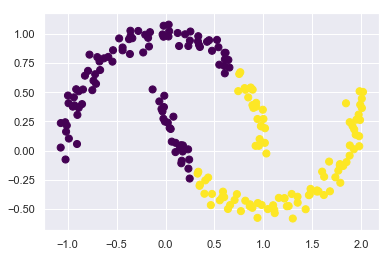

In [7]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

One way to overcome this limitation is to project the data into a higher dimension where a linear separation is possible. 

C:\Users\Giuseppe\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


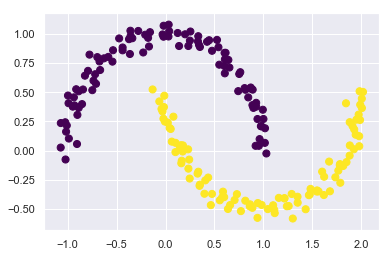

In [8]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

**4. k-means can be slow for large numbers of samples**

To overcome this, we might just use a subset of the data to update the cluster centers at each step. This is the idea behind _batch-based k-means algorithms_, one form of which is implemented in <code>sklearn.cluster.MiniBatchKMeans</code>.

### Example 1: k-means on digits

Here we will attempt to use k-means to try to identify similar digits _without using the original label information_.

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [10]:
# clustering
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

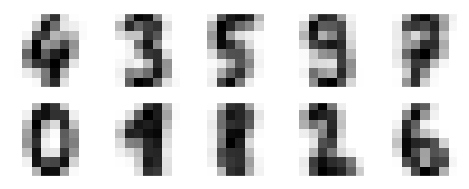

In [11]:
# visualize the clusters
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [12]:
# matching each learned cluster label with true label
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

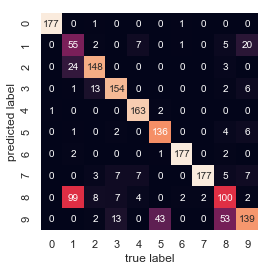

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Going one step further, we can preprocess using t-SNE (t-distributed stochastic neighbour embedding):

In [15]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

### Example 2: k-means for color compression

One interesting application of clustering is in color compression within images, where lots of pixel will have very similar (or identical) colors consuming memory.

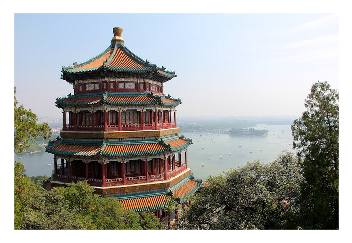

In [16]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [17]:
# height - width - RGB
china.shape

(427, 640, 3)

In [18]:
data = china / 255.0 # rescaling to 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Visualize these pixels in this color space, using a subset of 10,000 pixels:

In [19]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

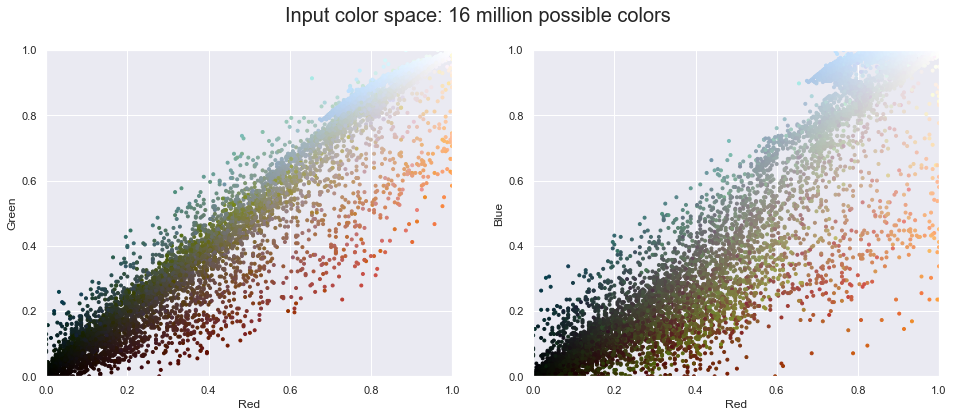

In [20]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just **16 colors**, using a k-means clustering across the pixel space.  

Because we are dealing with a very large dataset, we will use the <code>mini batch k-means</code>, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

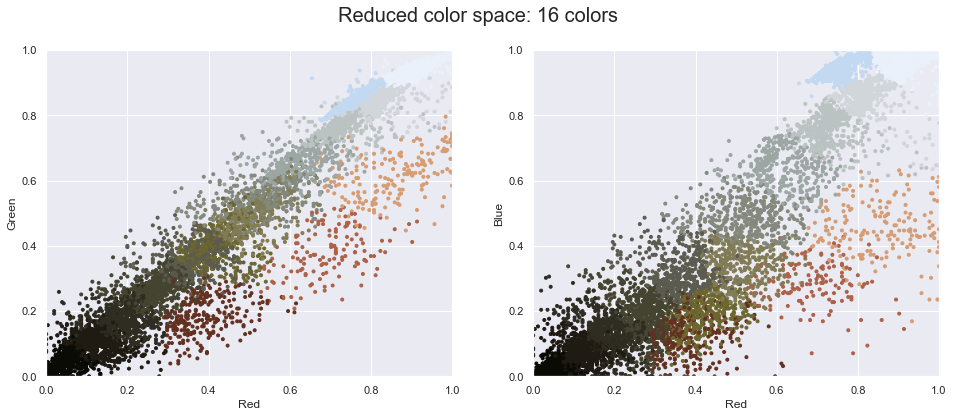

In [21]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

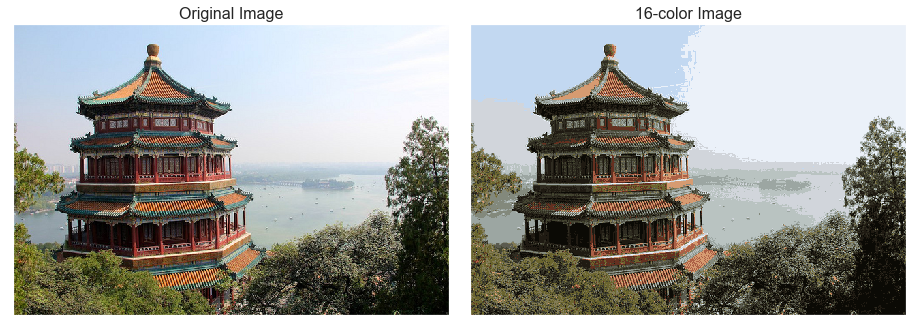

In [22]:
# recolor with only 16 colors
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Pretty good considering a compression rate of 1 million! 